In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

from utils.missing import (
    add_missing_ranges,
    calculate_missing_by_col
)
from utils.columns import inspect_column_values, check_binary_pattern
from utils.name_normalizer import normalize_column_name
from utils.clinical_matcher import match_clinical_columns, resolve_group_conflicts
from utils.clinical_cleaner import clean_clinical_matches, group_clinical_duplicates, resolve_duplicate_columns

PROJECT_ROOT = r"C:\Users\Tássio Sales\Documents\PIBIC\Códigos\Testes Base de dados Campina Grande"
EXCEL_DIR = os.path.join(PROJECT_ROOT, "data", "excel")

excel_files = sorted(glob.glob(os.path.join(EXCEL_DIR, "*.xlsx")))
print(f"Found {len(excel_files)} Excel files")

dfs = []

for file in excel_files:

    year = os.path.basename(file).split("_")[1].split(".")[0]

    df = pd.read_excel(file)

    df["YEAR_FILE"] = int(year)
    df["SOURCE_FILE"] = os.path.basename(file)

    dfs.append(df)

    print(f"Loaded {os.path.basename(file)} → shape {df.shape}")

df_all = pd.concat(dfs, ignore_index=True, sort=False)

df_all.columns = (
    df_all.columns
        .str.strip()
        .str.upper()
        .str.replace(" ", "_")
)

print("Final dataset shape:", df_all.shape)

Found 6 Excel files
Loaded dengue_2018.xlsx → shape (925, 148)
Loaded dengue_2021.xlsx → shape (272, 148)
Loaded dengue_2022.xlsx → shape (1646, 148)
Loaded dengue_2023.xlsx → shape (708, 148)
Loaded dengue_2024.xlsx → shape (3608, 148)
Loaded dengue_2025.xlsx → shape (3050, 148)
Final dataset shape: (10209, 148)


C:\Users\Tássio Sales\AppData\Local\Temp\ipykernel_18984\764277675.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(dfs, ignore_index=True, sort=False)
C:\Users\Tássio Sales\AppData\Local\Temp\ipykernel_18984\764277675.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(dfs, ignore_index=True, sort=False)
C:\Users\Tássio Sales\AppData\Local\Temp\ipykernel_18984\764277675.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA 

In [2]:
df_all.info()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10209 entries, 0 to 10208
Columns: 148 entries, NU_NOTIFIC to SOURCE_FILE
dtypes: datetime64[ns](16), float64(109), int64(16), object(7)
memory usage: 11.5+ MB


,NU_NOTIFIC,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,...,DT_TRANSRS,DT_TRANSSE,NU_LOTE_V,NU_LOTE_H,CS_FLXRET,FLXRECEBI,IDENT_MICR,MIGRADO_W,YEAR_FILE,SOURCE_FILE
0,46224,2,A90,2018-04-02,201814,2018,25,250400,1421.0,2363070,...,NaN,NaN,NaN,NaN,1,NaN,4.0,NaN,2018,dengue_2018.xlsx
1,46888,2,A90,2018-04-30,201818,2018,25,250400,1421.0,2363070,...,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,2018,dengue_2018.xlsx
2,46886,2,A90,2018-04-30,201818,2018,25,250400,1421.0,7113692,...,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,2018,dengue_2018.xlsx
3,48082,2,A90,2018-06-20,201825,2018,25,250400,1421.0,2362287,...,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,2018,dengue_2018.xlsx
4,21860,2,A90,2018-06-12,201824,2018,25,250400,1421.0,2362856,...,NaN,NaN,NaN,NaN,1,NaN,4.0,NaN,2018,dengue_2018.xlsx


In [3]:
print("=" * 70)
print("INITIAL DATASET SNAPSHOT")
print("=" * 70)

total_rows, total_cols = df_all.shape
total_missing = df_all.isna().sum().sum()

overall_missing_pct = (total_missing / (total_rows * total_cols)) * 100

print(f"Total rows: {total_rows}")
print(f"Total columns: {total_cols}")
print(f"Total missing values: {total_missing}")
print(f"Overall missing percentage: {overall_missing_pct:.2f}%")

INITIAL DATASET SNAPSHOT
Total rows: 10209
Total columns: 148
Total missing values: 886848
Overall missing percentage: 58.70%


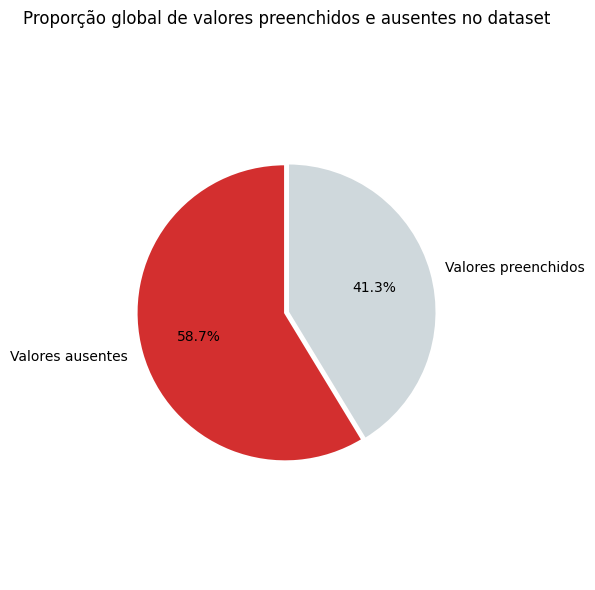

In [18]:
total_values = total_rows * total_cols
filled_values = total_values - total_missing

labels = ["Valores preenchidos", "Valores ausentes"]
values = [filled_values, total_missing]

colors = ["#CFD8DC", "#D32F2F"]  
explode = (0, 0.02)

plt.figure(figsize=(6, 6))
plt.pie(
    values,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct="%.1f%%",
    startangle=90,
    counterclock=False,
    wedgeprops={"edgecolor": "white", "linewidth": 1.5}
)

plt.title(
    "Proporção global de valores preenchidos e ausentes no dataset",
    pad=15
)

plt.axis("equal")
plt.tight_layout()
plt.show()

In [6]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)

missing_by_year = (
    df_all
        .groupby("YEAR_FILE")
        .apply(lambda x: x.isna().mean() * 100)
)

print("Missing data by year (%):")
display(missing_by_year)


Missing data by year (%):


C:\Users\Tássio Sales\AppData\Local\Temp\ipykernel_18984\3809677046.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.isna().mean() * 100)


,NU_NOTIFIC,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_SIN_PRI,SEM_PRI,DT_NASC,SOUNDEX,NU_IDADE_N,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_DISTRIT,ID_BAIRRO,NM_BAIRRO,ID_GEO1,ID_GEO2,CS_ZONA,ID_PAIS,DT_INVEST,ID_OCUPA_N,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,DT_CHIK_S1,DT_CHIK_S2,DT_PRNT,RES_CHIKS1,RES_CHIKS2,RESUL_PRNT,DT_SORO,RESUL_SORO,DT_NS1,RESUL_NS1,DT_VIRAL,RESUL_VI_N,DT_PCR,RESUL_PCR_,SOROTIPO,HISTOPA_N,IMUNOH_N,HOSPITALIZ,DT_INTERNA,UF,MUNICIPIO,HOSPITAL,DDD_HOSP,TEL_HOSP,TPAUTOCTO,COUFINF,COPAISINF,COMUNINF,CODISINF,CO_BAINF,NOBAIINF,CLASSI_FIN,CRITERIO,DOENCA_TRA,CLINC_CHIK,EVOLUCAO,DT_OBITO,DT_ENCERRA,ALRM_HIPOT,ALRM_PLAQ,ALRM_VOM,ALRM_SANG,ALRM_HEMAT,ALRM_ABDOM,ALRM_LETAR,ALRM_HEPAT,ALRM_LIQ,DT_ALRM,GRAV_PULSO,GRAV_CONV,GRAV_ENCH,GRAV_INSUF,GRAV_TAQUI,GRAV_EXTRE,GRAV_HIPOT,GRAV_HEMAT,GRAV_MELEN,GRAV_METRO,GRAV_SANG,GRAV_AST,GRAV_MIOC,GRAV_CONSC,GRAV_ORGAO,DT_GRAV,MANI_HEMOR,EPISTAXE,GENGIVO,METRO,PETEQUIAS,HEMATURA,SANGRAM,LACO_N,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,NU_LOTE_I,DS_OBS,TP_SISTEMA,NDUPLIC_N,DT_DIGITA,DT_TRANSUS,DT_TRANSDM,DT_TRANSSM,DT_TRANSRM,DT_TRANSRS,DT_TRANSSE,NU_LOTE_V,NU_LOTE_H,CS_FLXRET,FLXRECEBI,IDENT_MICR,MIGRADO_W,YEAR_FILE,SOURCE_FILE
YEAR_FILE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108108,0.0,0.0,0.0,0.108108,100.0,0.0,0.0,0.000000,0.0,4.864865,0.0,0.0,0.0,27.135135,8.324324,0.756757,100.000000,100.000000,0.756757,0.0,3.243243,69.729730,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,3.243243,98.162162,100.0,100.000000,98.270270,98.378378,98.378378,12.756757,7.567568,96.756757,14.918919,99.675676,16.108108,98.702703,15.351351,99.783784,18.162162,17.945946,27.891892,48.432432,48.216216,48.432432,49.405405,88.540541,88.540541,54.162162,57.729730,57.729730,58.054054,72.972973,74.054054,72.216216,0.000000,4.648649,100.0,99.243243,8.108108,98.702703,0.540541,95.891892,95.891892,95.891892,95.891892,95.891892,95.891892,95.891892,95.891892,95.891892,95.891892,99.459459,99.459459,99.459459,99.459459,99.459459,99.459459,99.459459,99.459459,99.459459,99.459459,99.459459,99.459459,99.459459,99.459459,99.459459,99.567568,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,36.432432,0.108108,100.0,0.108108,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,100.0,0.108108,100.0,0.0,0.0
2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.367647,0.0,0.0,0.0,0.367647,100.0,0.0,0.0,0.000000,0.0,10.661765,0.0,0.0,0.0,47.426471,17.647059,2.941176,100.000000,100.000000,2.573529,0.0,4.044118,51.470588,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,4.044118,98.161765,100.0,100.000000,98.161765,98.161765,98.161765,17.279412,23.897059,94.485294,31.250000,99.632353,28.676471,96.323529,27.573529,99.632353,34.558824,33.823529,9.926471,77.205882,77.205882,77.205882,77.573529,84.926471,84.926471,81.617647,83.823529,83.823529,84.191176,86.764706,87.500000,86.764706,0.000000,13.602941,100.0,98.897059,17.647059,99.632353,1.102941,99.264706,99.264706,99.264706,99.264706,99.264706,99.264706,99.264706,99.264706,99.264706,99.264706,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,81.985294,0.000000,100.0,0.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,

In [7]:
missing_by_col = calculate_missing_by_col(df_all)

print("Missing data by column (%):")
display(missing_by_col)

Missing data by column (%):


,missing_count,missing_pct
SOUNDEX,10209,100.000000
PLAQ_MENOR,10209,100.000000
EVIDENCIA,10209,100.000000
FLXRECEBI,10209,100.000000
NDUPLIC_N,10209,100.000000
SANGRAM,10209,100.000000
HEMATURA,10209,100.000000
PETEQUIAS,10209,100.000000
METRO,10209,100.000000
GENGIVO,10209,100.000000


In [8]:
columns_100pct_missing = missing_by_col[
    missing_by_col["missing_pct"] == 100
]

print(f"Total columns with 100% missing values: {len(columns_100pct_missing)}\n")

display(columns_100pct_missing)

Total columns with 100% missing values: 28



,missing_count,missing_pct
SOUNDEX,10209,100.0
PLAQ_MENOR,10209,100.0
EVIDENCIA,10209,100.0
FLXRECEBI,10209,100.0
NDUPLIC_N,10209,100.0
SANGRAM,10209,100.0
HEMATURA,10209,100.0
PETEQUIAS,10209,100.0
METRO,10209,100.0
GENGIVO,10209,100.0


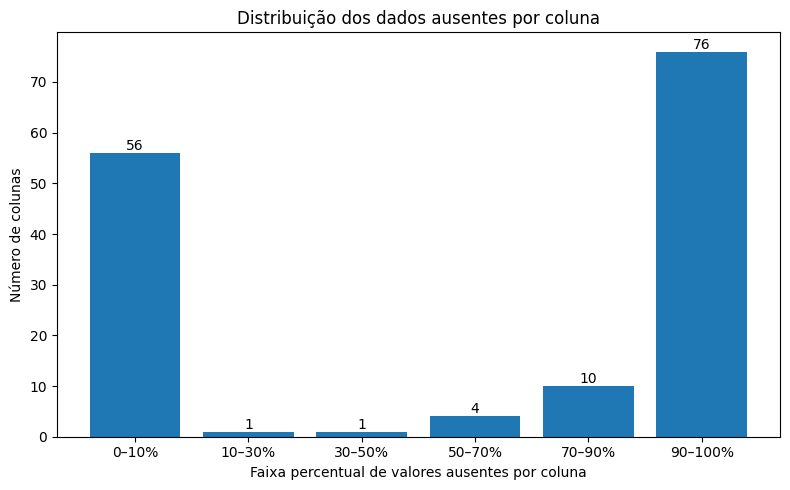

In [ ]:
range_counts = (
    missing_by_col["missing_range"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(8, 5))
plt.bar(range_counts.index.astype(str), range_counts.values)
plt.xlabel("Faixa percentual de valores ausentes por coluna")
plt.ylabel("Número de colunas")
plt.title("Distribuição dos dados ausentes por coluna")

for i, v in enumerate(range_counts.values):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [8]:
INSTABILITY_THRESHOLD = 80  # %

temporal_instability = (
    missing_by_year > INSTABILITY_THRESHOLD
).sum()

temporal_instability = (
    temporal_instability
        .sort_values(ascending=False)
        .rename("years_above_80pct_missing")
)

print("Temporally unstable columns:")
display(temporal_instability)

Temporally unstable columns:


SOUNDEX        6
NU_LOTE_I      6
DT_TRANSUS     6
NDUPLIC_N      6
MIGRADO_W      6
DT_TRANSRM     6
DT_TRANSSE     6
DT_PRNT        6
DT_CHIK_S1     6
DT_CHIK_S2     6
DT_VIRAL       6
DT_NS1         6
SOROTIPO       6
DDD_HOSP       6
TEL_HOSP       6
RES_CHIKS1     6
RES_CHIKS2     6
RESUL_PRNT     6
ID_GEO1        6
ID_GEO2        6
DT_TRANSRS     6
NU_LOTE_V      6
DT_TRANSSM     6
DT_GRAV        6
GRAV_AST       6
GRAV_ORGAO     6
GRAV_CONSC     6
GRAV_MIOC      6
GRAV_HEMAT     6
GRAV_HIPOT     6
GRAV_EXTRE     6
GRAV_TAQUI     6
GRAV_INSUF     6
GRAV_SANG      6
GRAV_METRO     6
GRAV_MELEN     6
GRAV_PULSO     6
GRAV_CONV      6
GRAV_ENCH      6
COMPLICA       6
CON_FHD        6
PLAQ_MENOR     6
EVIDENCIA      6
PLASMATICO     6
LACO_N         6
SANGRAM        6
HEMATURA       6
PETEQUIAS      6
METRO          6
DT_TRANSDM     6
NU_LOTE_H      6
FLXRECEBI      6
MANI_HEMOR     6
EPISTAXE       6
GENGIVO        6
DT_ALRM        6
ALRM_ABDOM     6
ALRM_LIQ       6
ALRM_HEPAT    

In [9]:
column_metadata = []

for col in df_all.columns:
    norm = normalize_column_name(col)
    column_metadata.append({
        "column": col,
        "base_name": norm["base_name"],
        "semantic_tokens": norm["semantic_tokens"],
        "structural_tokens": norm["structural_tokens"],
        "missing_pct": missing_by_col.loc[col, "missing_pct"]
    })

df_columns = pd.DataFrame(column_metadata)
df_columns.sort_values("missing_pct", ascending=False)

,column,base_name,semantic_tokens,structural_tokens,missing_pct
13,SOUNDEX,SOUNDEX,[SOUNDEX],[],100.000000
126,PLAQ_MENOR,PLAQ_MENOR,"[PLAQ, MENOR]",[],100.000000
125,EVIDENCIA,EVIDENCIA,[EVIDENCIA],[],100.000000
143,FLXRECEBI,FLXRECEBI,[FLXRECEBI],[],100.000000
132,NDUPLIC_N,NDUPLIC,[NDUPLIC],[N],100.000000
122,SANGRAM,SANGRAM,[SANGRAM],[],100.000000
121,HEMATURA,HEMATURA,[HEMATURA],[],100.000000
120,PETEQUIAS,PETEQUIAS,[PETEQUIAS],[],100.000000
119,METRO,METRO,[METRO],[],100.000000
118,GENGIVO,GENGIVO,[GENGIVO],[],100.000000


In [10]:
df_clinical_matches = match_clinical_columns(
    df=df_all,
    missing_by_col=missing_by_col,
    similarity_threshold=0.6,
)

display(df_clinical_matches)

,column,normalized_name,group,similarity_score,missing_pct
0,ALRM_ABDOM,ALRM_ABDOM,ALARM,0.667,99.22
1,ALRM_HEMAT,ALRM_HEMAT,ALARM,0.667,99.21
2,ALRM_HEPAT,ALRM_HEPAT,ALARM,0.667,99.21
3,ALRM_HIPOT,ALRM_HIPOT,ALARM,0.667,99.21
4,ALRM_LETAR,ALRM_LETAR,ALARM,0.769,99.22
5,ALRM_LIQ,ALRM_LIQ,ALARM,0.667,99.21
6,ALRM_PLAQ,ALRM_PLAQ,ALARM,0.727,99.21
7,ALRM_SANG,ALRM_SANG,ALARM,0.667,99.21
8,ALRM_VOM,ALRM_VOM,ALARM,0.667,99.23
9,ARTRALGIA,ARTRALGIA,ALARM,0.632,0.70


In [11]:
df_resolved = resolve_group_conflicts(df_clinical_matches)

display(df_resolved.sort_values("group"))
display(df_resolved.groupby("group").size())

,column,normalized_name,group,similarity_score,missing_pct
49,PLAQ_MENOR,PLAQ_MENOR,ALARM,0.727,100.00
1,ALRM_ABDOM,ALRM_ABDOM,ALARM,0.667,99.22
2,ALRM_HEMAT,ALRM_HEMAT,ALARM,0.667,99.21
3,ALRM_HEPAT,ALRM_HEPAT,ALARM,0.667,99.21
4,ALRM_HIPOT,ALRM_HIPOT,ALARM,0.667,99.21
5,ALRM_LETAR,ALRM_LETAR,ALARM,0.769,99.22
6,ALRM_LIQ,ALRM_LIQ,ALARM,0.667,99.21
7,ALRM_PLAQ,ALRM_PLAQ,ALARM,0.727,99.21
8,ALRM_SANG,ALRM_SANG,ALARM,0.667,99.21
9,ALRM_VOM,ALRM_VOM,ALARM,0.667,99.23


group
ALARM          13
COMORBIDITY     7
SEVERITY       17
SYMPTOM        17
dtype: int64

In [12]:

df_clean = clean_clinical_matches(df_resolved)

display(df_clean.sort_values("group"))
display(df_clean.groupby("group").size())

,column,normalized_name,group,similarity_score,missing_pct
1,ALRM_ABDOM,ALRM_ABDOM,ALARM,0.667,99.22
2,ALRM_HEMAT,ALRM_HEMAT,ALARM,0.667,99.21
3,ALRM_HEPAT,ALRM_HEPAT,ALARM,0.667,99.21
4,ALRM_HIPOT,ALRM_HIPOT,ALARM,0.667,99.21
5,ALRM_LETAR,ALRM_LETAR,ALARM,0.769,99.22
6,ALRM_LIQ,ALRM_LIQ,ALARM,0.667,99.21
7,ALRM_PLAQ,ALRM_PLAQ,ALARM,0.727,99.21
8,ALRM_SANG,ALRM_SANG,ALARM,0.667,99.21
9,ALRM_VOM,ALRM_VOM,ALARM,0.667,99.23
48,PLAQ_MENOR,PLAQ_MENOR,ALARM,0.727,100.00


group
ALARM          12
COMORBIDITY     7
SEVERITY       17
SYMPTOM        16
dtype: int64

In [13]:
df_duplicates = group_clinical_duplicates(df_clinical_matches)

display(df_duplicates)

,column,normalized_name,group,similarity_score,missing_pct,canonical_name,dup_key,duplicate_group
0,LACO,LACO,SYMPTOM,1.000,0.7,laco,SYMPTOM__laco,laco
1,LACO_N,LACO,SYMPTOM,1.000,100.0,laco,SYMPTOM__laco,laco
2,PETEQUIA_N,PETEQUIA,SYMPTOM,1.000,0.7,petequia,SYMPTOM__petequia,petequia
3,PETEQUIAS,PETEQUIAS,SYMPTOM,0.941,100.0,petequia,SYMPTOM__petequia,petequia


In [14]:
df_kept, df_removed = resolve_duplicate_columns(df_duplicates)

print("Retained columns:")
display(df_kept)

print("Removed columns:")
display(df_removed)

Retained columns:


,column,normalized_name,group,similarity_score,missing_pct,canonical_name,dup_key,duplicate_group
0,LACO,LACO,SYMPTOM,1.0,0.7,laco,SYMPTOM__laco,laco
1,PETEQUIA_N,PETEQUIA,SYMPTOM,1.0,0.7,petequia,SYMPTOM__petequia,petequia


Removed columns:


,column,normalized_name,group,similarity_score,missing_pct,canonical_name,dup_key,duplicate_group,kept_column,kept_missing_pct,removal_reason
0,LACO_N,LACO,SYMPTOM,1.000,100.0,laco,SYMPTOM__laco,laco,LACO,0.7,higher_missing_pct
1,PETEQUIAS,PETEQUIAS,SYMPTOM,0.941,100.0,petequia,SYMPTOM__petequia,petequia,PETEQUIA_N,0.7,higher_missing_pct


In [15]:
COLUMNS_TO_REMOVE = [   
    "PLAQ_MENOR",
    "METRO",
    "SANGRAM",
    "HEMATURA",
    "MANI_HEMOR",   
    "LACO_N",
    "PETEQUIAS",
]

df_all = df_all.drop(
    columns=[c for c in COLUMNS_TO_REMOVE if c in df_all.columns],
    errors="ignore"
)

df_clean = df_clean[
    ~df_clean["column"].isin(COLUMNS_TO_REMOVE)
].reset_index(drop=True)

print("Removed columns:\n")
print(COLUMNS_TO_REMOVE)
print("\n")
print("Total number of columns remaining in df_all:", df_all.shape[1])

display(df_clean.groupby("group").size())
display(df_clean.sort_values(["group", "missing_pct"]))

Removed columns:

['PLAQ_MENOR', 'METRO', 'SANGRAM', 'HEMATURA', 'MANI_HEMOR', 'LACO_N', 'PETEQUIAS']


Total number of columns remaining in df_all: 141


group
ALARM           9
COMORBIDITY     7
SEVERITY       15
SYMPTOM        14
dtype: int64

,column,normalized_name,group,similarity_score,missing_pct
2,ALRM_HEMAT,ALRM_HEMAT,ALARM,0.667,99.21
3,ALRM_HEPAT,ALRM_HEPAT,ALARM,0.667,99.21
4,ALRM_HIPOT,ALRM_HIPOT,ALARM,0.667,99.21
6,ALRM_LIQ,ALRM_LIQ,ALARM,0.667,99.21
7,ALRM_PLAQ,ALRM_PLAQ,ALARM,0.727,99.21
8,ALRM_SANG,ALRM_SANG,ALARM,0.667,99.21
1,ALRM_ABDOM,ALRM_ABDOM,ALARM,0.667,99.22
5,ALRM_LETAR,ALRM_LETAR,ALARM,0.769,99.22
9,ALRM_VOM,ALRM_VOM,ALARM,0.667,99.23
0,ACIDO_PEPT,ACIDO_PEPT,COMORBIDITY,0.667,0.70


In [16]:
clinical_columns = df_clean["column"].tolist()

df_values = inspect_column_values(df_all, clinical_columns)
display(df_values)


,column,n_unique,unique_values
0,ACIDO_PEPT,2,"[2.0, 1.0]"
1,ALRM_ABDOM,2,"[2.0, 1.0]"
2,ALRM_HEMAT,2,"[2.0, 1.0]"
3,ALRM_HEPAT,2,"[2.0, 1.0]"
4,ALRM_HIPOT,2,"[2.0, 1.0]"
5,ALRM_LETAR,2,"[2.0, 1.0]"
6,ALRM_LIQ,2,"[2.0, 1.0]"
7,ALRM_PLAQ,2,"[2.0, 1.0]"
8,ALRM_SANG,2,"[1.0, 2.0]"
9,ALRM_VOM,2,"[2.0, 1.0]"


In [17]:
df_pattern = check_binary_pattern(df_all, clinical_columns)
display(df_pattern)

,column,unique_values,status
0,ACIDO_PEPT,"[1.0, 2.0]",OK
1,GRAV_EXTRE,"[1.0, 2.0]",OK
2,GRAV_HEMAT,"[1.0, 2.0]",OK
3,GRAV_HIPOT,"[1.0, 2.0]",OK
4,GRAV_INSUF,"[1.0, 2.0]",OK
5,GRAV_MELEN,"[1.0, 2.0]",OK
6,GRAV_METRO,[2.0],OK
7,GRAV_MIOC,[2.0],OK
8,GRAV_ORGAO,"[1.0, 2.0]",OK
9,GRAV_PULSO,[2.0],OK
